In [1]:
#!/usr/bin/env python
# coding: utf-8

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Define paths
DATA_PATH = "../data/processed/images"

This notebook will implement a basic VGG-16 model to classify skin conditions into binary categories (e.g., benign vs. malignant).

In [3]:
# 1. Data Preparation

class SkinConditionDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Convert three_partition_label to binary (malignant vs. non-malignant)
        self.data_frame['binary_label'] = self.data_frame['three_partition_label'].apply(
            lambda x: 1 if x == 'malignant' else 0
        )
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx]['image_path']
        image = plt.imread(img_path)
        
        # Convert grayscale to RGB if needed
        if len(image.shape) == 2:
            image = np.stack((image,)*3, axis=-1)
        
        # Get binary label
        label = self.data_frame.iloc[idx]['binary_label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [6]:
def load_data():
    # Define transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = SkinConditionDataset(
        csv_file=os.path.join(DATA_PATH, 'train_split.csv'),
        root_dir=DATA_PATH,
        transform=transform
    )
    
    val_dataset = SkinConditionDataset(
        csv_file=os.path.join(DATA_PATH, 'val_split.csv'),
        root_dir=DATA_PATH,
        transform=transform
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader

train_loader, val_loader = load_data()

# 2. Building the Model

In [7]:
# 2. Building the Model
class BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(BinaryClassifier, self).__init__()
        # Load pre-trained VGG16
        self.vgg = models.vgg16(pretrained=pretrained)
        
        # Replace the final layer for binary classification
        num_features = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Linear(num_features, 1)
        
        # Add sigmoid for binary classification
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.vgg(x)
        return self.sigmoid(x)

In [ ]:
# Create model
def create_model():
    # Use a smaller model like ResNet18 instead of VGG16
    model = models.resnet18(pretrained=True)
    # Replace the final layer for binary classification
    model.fc = nn.Linear(model.fc.in_features, 1)
    # Add sigmoid for binary classification
    model = nn.Sequential(
        model,
        nn.Sigmoid()
    )
    return model

# Use this when creating your model
model = create_model()

#model = BinaryClassifier(pretrained=True)

/Users/mmnguyen/.local/share/mise/installs/python/3.10.16/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mmnguyen/.local/share/mise/installs/python/3.10.16/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/mmnguyen/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 105MB/s]  


3. Train Model

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device).view(-1, 1)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.float().to(device).view(-1, 1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        
        print(f'Validation Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'binary_classifier.pth')
    
    return model

In [10]:
# 3. Training the Model
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
# Train model
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.4477, Acc: 0.8132
Validation Loss: 0.3598, Acc: 0.8302
Epoch 2/10, Loss: 0.3169, Acc: 0.8739
Validation Loss: 0.3031, Acc: 0.8782
Epoch 3/10, Loss: 0.2216, Acc: 0.9136
Validation Loss: 0.3439, Acc: 0.8902
Epoch 4/10, Loss: 0.1376, Acc: 0.9449
Validation Loss: 0.4784, Acc: 0.8799
Epoch 5/10, Loss: 0.1384, Acc: 0.9526
Validation Loss: 0.2785, Acc: 0.8937
Epoch 6/10, Loss: 0.0906, Acc: 0.9603
Validation Loss: 0.4030, Acc: 0.9005
Epoch 7/10, Loss: 0.0510, Acc: 0.9816
Validation Loss: 0.4288, Acc: 0.8954
Epoch 8/10, Loss: 0.0242, Acc: 0.9919
Validation Loss: 0.3977, Acc: 0.8834
Epoch 9/10, Loss: 0.0526, Acc: 0.9809
Validation Loss: 0.5706, Acc: 0.8937
Epoch 10/10, Loss: 0.0577, Acc: 0.9846
Validation Loss: 0.3308, Acc: 0.9005


4. Evaluate Model

In [11]:
# Add tester data
# Add a test data loader
def load_test_data():
    # Define transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Create test dataset
    test_dataset = SkinConditionDataset(
        csv_file=os.path.join(DATA_PATH, 'test_split.csv'),
        root_dir=DATA_PATH,
        transform=transform
    )
    
    # Create dataloader
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return test_loader

test_loader = load_test_data()


In [12]:
# 4. Evaluate the Model
def evaluate_model(model, test_loader):
    """
    Evaluate the model on test data and return detailed metrics
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = (outputs > 0.5).float().cpu().numpy().flatten()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = np.mean(all_preds == all_labels)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    
    # Calculate sensitivity (recall), specificity, precision, and F1 score
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=['Non-Malignant', 'Malignant']))
    
    # Create confusion matrix visualization
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Malignant', 'Malignant'],
                yticklabels=['Non-Malignant', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Return metrics as a dictionary
    metrics = {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1_score,
        'confusion_matrix': cm
    }
    
    return metrics


               precision    recall  f1-score   support

Non-Malignant       0.95      0.94      0.94       479
    Malignant       0.72      0.75      0.74       105

     accuracy                           0.90       584
    macro avg       0.84      0.84      0.84       584
 weighted avg       0.91      0.90      0.90       584



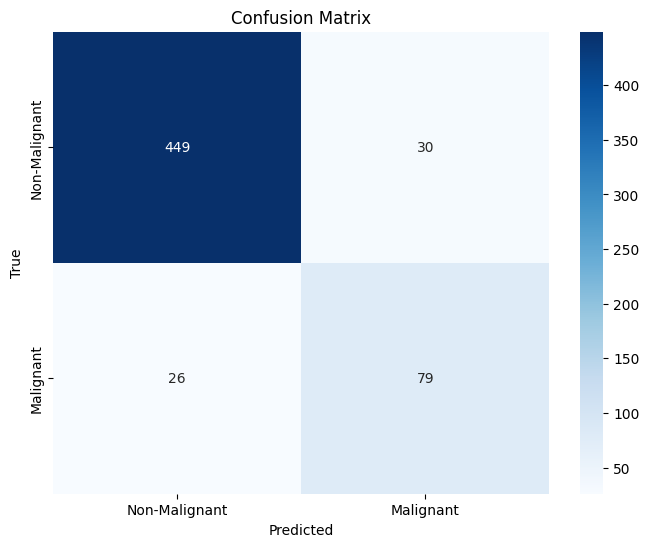

Accuracy: 0.9041
Sensitivity: 0.7524
Specificity: 0.9374
Precision: 0.7248
F1 Score: 0.7383


In [13]:
import seaborn as sns
# Evaluate the model
metrics = evaluate_model(model, test_loader)
# Print metrics
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Sensitivity: {metrics['sensitivity']:.4f}")
print(f"Specificity: {metrics['specificity']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")

In [15]:
# 5. Save the model
torch.save(model.state_dict(), 'basic_classification_model.pth')